## Set up


In [65]:
# Imports

import nltk
nltk.download("punkt")

# !pip install gensim
import gensim

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import Dataset, random_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import codecs
import os

import tensorboard as tb
import tensorflow as tf

import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm
import random

writer = SummaryWriter('runs/word2vec')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2021-03-01 00:12:35--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-03-01 00:12:35--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-03-01 00:12:35--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [66]:
# Setting random seed and device
SEED = 1

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# mount drive
if not os.path.exists('/content/drive/MyDrive/ICL AI/NLP/NLP_cw'):
    print("making dir")
    os.makedirs('/content/drive/MyDrive/ICL AI/NLP/NLP_cw')

root_path = '/content/drive/MyDrive/ICL AI/NLP/NLP_cw/'

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Hyperparameters and data loading


In [67]:
# Load data for testing purposes
# Data is stored locally in my drive at [root]/data/task-1
train_df = pd.read_csv(f'{root_path}train.csv')
test_df = pd.read_csv(f'{root_path}dev.csv')

# make sure data is in same folder as root dir!
# train_df = pd.read_csv('train.csv')
# test_df = pd.read_csv('dev.csv')

In [68]:
# Number of epochs
epochs = 10

# Proportion of training data for train compared to dev
train_proportion = 0.8

# which batch size?
BATCH_SIZE = 32  # hyperparam

In [69]:
# which model?
# affects:
# - train/evaluation, as BiLSTM has an extra hidden layer initialisation step
# - creation of features, as BiLSTM features are padded within batches and FFN
#   features are padded within the entire dataset

options_models = ["BiLSTM", "BiLSTM-Attention", "FFN"]

model_to_run = 1  # 0 = BiLSTM, 1 = BiLSTM-Attention, 2 = FFN

# which embedding?
# affects:
# - which embeddings file is loaded and used to make word2id, idx2word & wvecs
# - which tokenizer is used, as GloVe doesn't play nice with the ntkl tokenizer

options = [f'{root_path}glove.6B.100d.txt', 'custom_word2vec.txt', "custom_fasttext.txt"]

picked_embeddings = 1  # 0 = pre-made glove, 1 = custom word2vec, 2 = custom fasttext

# file to load the embeddings from
# embedding files should be txt and located in the same working dir as the .ipynb
file_to_load = options[picked_embeddings]  

## Preprocessing


### Making vocabulary


In [70]:
def create_vocab(data):
    """
    Creating a corpus of all the tokens used
    """
    tokenized_corpus = [] # Let us put the tokenized corpus in a list
    punctuation_exclusion = [",", "\'", "\"", ".", "‘", "’"] 

    for sentence in data:

        if picked_embeddings == 0: # glove embeddings

          tokenized_sentence = []
          for token in sentence.split(' '): # simplest split is
            tokenized_sentence.append(token)

            # tokenized_corpus.append(tokenized_sentence)
        else:
          # using nltk tokenizer        
          tokenized_sentence = nltk.tokenize.word_tokenize(sentence.lower())

        cleaned = [token for token in tokenized_sentence if token not in punctuation_exclusion]
        tokenized_corpus.append(cleaned)

    # Create single list of all vocabulary
    vocabulary = []  # Let us put all the tokens (mostly words) appearing in the vocabulary in a list

    for sentence in tokenized_corpus:

        for token in sentence:

            if token not in vocabulary:

                if True:
                    vocabulary.append(token)

    return vocabulary, tokenized_corpus

### Padding

In [71]:
def collate_fn_padd(batch):
    '''
    We add padding to our minibatches and create tensors for our model
    '''

    batch_labels = [l for f, l in batch]
    batch_features = [f for f, l in batch]

    batch_features_len = [len(f) for f, l in batch]

    seq_tensor = torch.zeros((len(batch), max(batch_features_len))).long()

    for idx, (seq, seqlen) in enumerate(zip(batch_features, batch_features_len)):
        seq_tensor[idx, :seqlen] = torch.LongTensor(seq)

    batch_labels = torch.FloatTensor(batch_labels)

    return seq_tensor, batch_labels

class Task1Dataset(Dataset):

    def __init__(self, train_data, labels):
        self.x_train = train_data
        self.y_train = labels

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, item):
        return self.x_train[item], self.y_train[item]

## Model


### BiLSTM

copied from spec

In [72]:
class BiLSTM(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, batch_size, device):
        super(BiLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.device = device
        self.batch_size = batch_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2label = nn.Linear(hidden_dim * 2, 1)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly why they have this dimensionality.
        # The axes semantics are (num_layers * num_directions, minibatch_size, hidden_dim)
        return torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device), \
               torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device)

    def forward(self, sentence):
        embedded = self.embedding(sentence)
        embedded = embedded.permute(1, 0, 2)

        lstm_out, self.hidden = self.lstm(
            embedded.view(len(embedded), self.batch_size, self.embedding_dim), self.hidden)

        out = self.hidden2label(lstm_out[-1])
        return out

### Custom NN

#### BiLSTM Attention

In [73]:
class BiLSTM_ATT(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, batch_size, device):
        super(BiLSTM_ATT, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.device = device
        self.batch_size = batch_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2label = nn.Linear(hidden_dim * 2, 1)
        self.hidden = self.init_hidden()
        
        # Attention layers
        self.attention_linear = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim * 2, bias = True),
            nn.Tanh(),
        )
        self.attention_softmax = nn.Softmax(dim = 0)


    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly why they have this dimensionality.
        # The axes semantics are (num_layers * num_directions, minibatch_size, hidden_dim)
        return torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device), \
               torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device)

    def forward(self, sentence):
        embedded = self.embedding(sentence)
        embedded = embedded.permute(1, 0, 2)
        lstm_out, self.hidden = self.lstm(
            embedded.view(len(embedded), self.batch_size, self.embedding_dim), self.hidden)
        
        # Attention Layers
        att_in = lstm_out
        # Linear operation
        att_linear = self.attention_linear(att_in[-1])
        
        # Apply softmax to get weight of h_ti, t being the num of length of embedded, i being our embedding dim
        att_softmax = self.attention_softmax(att_linear)

        # Extract feature vector
        # Here we extract SUM_(j=1)^t w_i * h_i
        feature_vector = torch.sum(att_softmax * att_in, dim=0)
        # Feature vector now has size batch size * embedding dim

        out = self.hidden2label(feature_vector)
        return out

#### Pytorch dense NN

Also attempted a GRU, but it didn't work, so stuck with feed-forward NN

In [74]:
class FFN(nn.Module):
    def __init__(self, embedding_dim, vocab_size, batch_size, max_feature):
        super(FFN, self).__init__()
        self.embedding_dim = embedding_dim
        self.batch_size = batch_size

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.model = nn.Sequential(
            nn.Linear(embedding_dim*max_feature, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Tanh()
        )

    def forward(self, x):
      # input shape: [batch size, sentence length]
      input_len = x.size()[1]

      # print("input size:", x.size()) 
      # print("input: ", x)

      # embedding output shape: [batch size, sentence length, embedding dim]
      embedded = self.embedding(x).view((self.batch_size, -1))

      out = self.model(embedded)
      return out

## Train & eval


In [75]:
# We define our training loop
def train(train_iter, dev_iter, model, number_epoch):
    """
    Training loop for the model, which calls on eval to evaluate after each epoch
    """

    
    print("Training model.")
    print(type(model).__name__)

    test_loss = []
    valid_loss_l = []
    test_mse = []
    valid_mse_l = []
    test_rmse = []
    valid_rmse_l = []

    for epoch in range(1, number_epoch+1):

        model.train()
        epoch_loss = 0
        epoch_sse = 0
        no_observations = 0  # Observations used for training so far

        for batch in train_iter:

            feature, target = batch

            feature, target = feature.to(device), target.to(device)

            # for RNN:
            model.batch_size = target.shape[0]
            no_observations = no_observations + target.shape[0]

            # initalise hidden layers for BiLSTM (& BiLSTM w/ attention) only
            if model_to_run == 0 or model_to_run == 1:  
              model.hidden = model.init_hidden()

            predictions = model(feature).squeeze(1)

            optimizer.zero_grad()

            loss = loss_fn(predictions, target)

            sse, __ = model_performance(predictions.detach().cpu().numpy(), target.detach().cpu().numpy())

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse

        valid_loss, valid_mse, __, __ = eval(dev_iter, model)

        epoch_loss, epoch_mse = epoch_loss / no_observations, epoch_sse / no_observations
        print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.2f} | Train MSE: {epoch_mse:.2f} | Train RMSE: {epoch_mse**0.5:.2f} | \
        Val. Loss: {valid_loss:.2f} | Val. MSE: {valid_mse:.2f} |  Val. RMSE: {valid_mse**0.5:.2f} |')

        test_loss.append(epoch_loss)
        valid_loss_l.append(valid_loss)
        test_mse.append(epoch_mse)
        valid_mse_l.append(valid_mse)
        test_rmse.append(epoch_mse**.5)
        valid_rmse_l.append(valid_mse**.5)
    return test_loss, test_mse, test_rmse, valid_loss_l, valid_mse_l, valid_rmse_l

In [76]:

# We evaluate performance on our dev set
def eval(data_iter, model):
    """
    Evaluating model performance on the dev set
    """
    model.eval()
    epoch_loss = 0
    epoch_sse = 0
    pred_all = []
    trg_all = []
    no_observations = 0

    with torch.no_grad():
        for batch in data_iter:
            feature, target = batch

            feature, target = feature.to(device), target.to(device)

            # for RNN:
            model.batch_size = target.shape[0]
            no_observations = no_observations + target.shape[0]
            if model_to_run == 0 or model_to_run == 1:
              model.hidden = model.init_hidden()

            predictions = model(feature).squeeze(1)
            loss = loss_fn(predictions, target)

            # We get the mse
            pred, trg = predictions.detach().cpu().numpy(), target.detach().cpu().numpy()
            sse, __ = model_performance(pred, trg)

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse
            pred_all.extend(pred)
            trg_all.extend(trg)

    return epoch_loss/no_observations, epoch_sse/no_observations, np.array(pred_all), np.array(trg_all)

In [77]:
# How we print the model performance
def model_performance(output, target, print_output=False):
    """
    Returns SSE and MSE per batch (printing the MSE and the RMSE)
    """

    sq_error = (output - target)**2

    sse = np.sum(sq_error)
    mse = np.mean(sq_error)
    rmse = np.sqrt(mse)

    if print_output:
        print(f'| MSE: {mse:.2f} | RMSE: {rmse:.2f} |')

    return sse, mse

## Pre-trained embeddings


#### Edit original data

In [78]:
# Edit original sentences
# replace word in original sentence with edit substitution

import re

original_training_data = train_df['original']
train_edit = train_df['edit']
original_test_data = test_df['original']
test_edit = test_df['edit']

train_edited = [re.sub('<(.+)/>', '<' + edit +'/>', data) for data, edit in zip(original_training_data, train_edit)]
test_edited = [re.sub('<(.+)/>', '<' + edit + '/>', data) for data, edit in zip(original_test_data, test_edit)]

train_df['full_edited'] = train_edited
test_df['full_edited'] = test_edited

#### Setting data, creating vocab

In [79]:
# We set our training data and test data
training_data = train_df['full_edited']
test_data = test_df['full_edited']

# Creating word vectors
training_vocab, training_tokenized_corpus = create_vocab(training_data)
test_vocab, test_tokenized_corpus = create_vocab(test_data)

# Creating joint vocab from test and train:
joint_vocab, joint_tokenized_corpus = create_vocab(pd.concat([training_data, test_data]))

print("Train & development vocab created.")


Vocab created.


In [19]:
print(joint_tokenized_corpus[:10])

[['France', 'is', 'hunting', 'down', 'its', 'citizens', 'who', 'joined', '<twins/>', 'without', 'trial', 'in', 'Iraq'], ['Pentagon', 'claims', '2,000', '%', 'increase', 'in', 'Russian', 'trolls', 'after', '<bowling/>', 'strikes', 'What', 'does', 'that', 'mean', '?'], ['Iceland', 'PM', 'Calls', 'Snap', 'Vote', 'as', 'Pedophile', 'Furor', 'Crashes', '<party/>', ''], ['In', 'an', 'apparent', 'first', 'Iran', 'and', 'Israel', '<slap/>', 'each', 'other', 'militarily'], ['Trump', 'was', 'told', 'weeks', 'ago', 'that', 'Flynn', 'misled', '<school/>', 'President'], ['All', '22', '<sounds/>', 'Trump', 'made', 'in', 'his', 'speech', 'to', 'Congress', 'in', 'one', 'chart'], ['New', 'DOJ', 'alert', 'system', 'will', 'flag', '<laughter/>', 'against', 'police'], ['As', 'Someone', 'Who', 'Grew', 'Up', 'Among', 'Fundamentalist', '<morons/>', 'In', 'The', 'US', 'I', "'m", 'Surprised', 'Anyone', "'s", 'Surprised', 'About', 'Roy', 'Moore'], ['Canadians', 'may', 'pay', 'more', 'taxes', 'than', 'Americans'

#### Creating embeddings
Pre-trained embeddings (GloVE) should be saved in the same folder as the embeddings created here. This is usually the working directory.

##### word2vec embeddings (custom)

Don't run, takes forever....

In [ ]:
# corpus to vocab

# already have train_vocab, train_token_corpus, test_vocab, test_corpus & joint
print("LENGTH OF HOINT VOCAB:", len(joint_vocab), "\nVOCAB:", joint_vocab)

# creating custom word2idx
word2idx = {}
n_words = 0

for token in joint_vocab:
    if token not in word2idx:
        word2idx[token] = n_words
        n_words += 1
        
assert len(word2idx) == len(joint_vocab)

LENGTH OF HOINT VOCAB: 14313 
VOCAB: ['France', 'is', 'hunting', 'down', 'its', 'citizens', 'who', 'joined', '<', 'Isis/', '>', '’', 'without', 'trial', 'in', 'Iraq', 'Pentagon', 'claims', '2,000', '%', 'increase', 'Russian', 'trolls', 'after', 'Syria/', 'strikes', 'What', 'does', 'that', 'mean', '?', 'Iceland', 'PM', 'Calls', 'Snap', 'Vote', 'as', 'Pedophile', 'Furor', 'Crashes', 'Coalition/', 'In', 'an', 'apparent', 'first', 'Iran', 'and', 'Israel', 'engage/', 'each', 'other', 'militarily', 'Trump', 'was', 'told', 'weeks', 'ago', 'Flynn', 'misled', 'Vice/', 'President', 'All', '22', 'promises/', 'made', 'his', 'speech', 'to', 'Congress', 'one', 'chart', 'New', 'DOJ', 'alert', 'system', 'will', 'flag', 'crimes/', 'against', 'police', 'As', 'Someone', 'Who', 'Grew', 'Up', 'Among', 'Fundamentalist', 'Christians/', 'The', 'US', 'I', "'m", 'Surprised', 'Anyone', "'s", 'About', 'Roy', 'Moore', 'Canadians', 'may', 'pay', 'more', 'taxes', 'than', 'Americans', 'but', 'here', 'what', 'they', '

In [ ]:
# window size = 2 = bigram

def get_focus_context_pairs(tokenized_corpus, window_size=2):
    focus_context_pairs = []
    for sentence in tokenized_corpus:

        for token_idx, token in enumerate(sentence):
            for w in range(-window_size, window_size+1):
                context_word_pos = token_idx + w

                if w == 0 or context_word_pos >= len(sentence) or context_word_pos < 0:
                    continue

                try:
                    focus_context_pairs.append([token, sentence[context_word_pos]])
                except:
                    continue
    
    return focus_context_pairs
  
focus_context_pairs = get_focus_context_pairs(joint_tokenized_corpus)
print(focus_context_pairs[:10])  # preview

# from word pairs to inded pairs
def get_focus_context_idx(focus_context_pairs):
    idx_pairs = []
    for pair in focus_context_pairs:
        idx_pairs.append([word2idx[pair[0]], word2idx[pair[1]]])
    
    return idx_pairs

idx_pairs = get_focus_context_idx(focus_context_pairs)
print(idx_pairs[:10])

[['France', 'is'], ['France', '‘'], ['is', 'France'], ['is', '‘'], ['is', 'hunting'], ['‘', 'France'], ['‘', 'is'], ['‘', 'hunting'], ['‘', 'down'], ['hunting', 'is']]
[[0, 1], [0, 2], [1, 0], [1, 2], [1, 3], [2, 0], [2, 1], [2, 3], [2, 4], [3, 1]]


In [ ]:
# one hot encoding of above indices
def get_one_hot(indicies, vocab_size=len(joint_vocab)):
    oh_matrix = np.zeros((len(indicies), vocab_size))
    for i, idx in enumerate(indicies):
        oh_matrix[i, idx] = 1

    return torch.Tensor(oh_matrix)

In [ ]:
# setting up word2vec

class Word2Vec(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim_size):
        super().__init__()
        
        self.projection = nn.Linear(input_size, hidden_dim_size, bias=False)
        self.output = nn.Linear(hidden_dim_size, output_size)
        
    def forward(self, input_token):
        x = self.projection(input_token)
        output = self.output(x)
        return output


# setting up training loop
def train(word2vec_model, idx_pairs, state_dict_filename, early_stop=False, num_epochs=10, lr=1e-3):

    word2vec_model.train()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(word2vec_model.parameters(), lr=lr)

    for epoch in tqdm(range(num_epochs)):

        random.shuffle(idx_pairs)

        for focus, context in idx_pairs:
            print(focus)
            oh_inputs = get_one_hot([focus], len(joint_vocab))
            target = torch.LongTensor([context])

            pred_outputs = word2vec_model(oh_inputs)

            loss = criterion(pred_outputs, target)

            loss.backward()
            optimizer.step()
            word2vec_model.zero_grad()
            
        ### These lines stop training early
            if early_stop: break
        if early_stop: break
        ###


        torch.save(word2vec_model.state_dict(), state_dict_filename)
        writer.add_embedding(word2vec_model.projection.weight.T,
                             metadata=word2idx.keys(), global_step=epoch)

tf.io.gfile = tb.compat.tensorflow_stub.io.gfile  # so saving doesnt run into issues



In [ ]:
# create the embeddings
word2vec = Word2Vec(len(joint_vocab), len(joint_vocab), 10)  # hyperparam hidden dim = 50
train(word2vec, idx_pairs, "word2vec.pt")

  0%|          | 0/10 [00:00<?, ?it/s]

829
361
3141
3712
9423
156
32
750
156
344
339
7595
41
1590
105
12259
6931
48
46
3836
5035
11225
245
3786
1671
3280
46
384
1811
46
46
10550
1680
4203
1447
3020
46
12291
96
5055
6159
54
160
73
1577
13
10
110
2148
13
54
6859
10704
92
54
113
1880
3324
2847
7368
1286
3380
5765
13
11423
41
96
1960
14097
476
112
4779
4930
448
4401
3512
8717
2478
593
2877
601
3754
147
383
855
11330
341
156
69
4141
12375
797
7
1937
4799
497
355
112
8065
245
10265
6124
170
2122
328
3160
112
35
173
379
43
742
69
3936
2020
9454
2129
46
69
103
4490
97
480
11246
4321
245
401
9465
13684
321
1589
696
46
147
69
6917
3580
474
8363
8598
10145
552
13671
147
474
7319
147
1177
546
764
156
355
706
286
232
383
245
69
1663
7711
10448
156
8893
1436
14126
20
55
13
5206
9413
1893
3251
156
156
649
686
1488
46
2322
2190
232
232
42
245
69
245
48
791
11202
14263
142
13666
147
605
359
8988
13667
7303
27
13171
5853
2401
7358
1514
8237
12080
46
54
508
657
433
957
1654
1163
7884
1348
41
2579
5014
5360
67
5414
147
245
5955
4987
11751
68
2

  0%|          | 0/10 [00:05<?, ?it/s]

46
10204
789
43
147
46
3403
47
4039
4707
9724
112
36
548
69
245
2199
11260
1021
341
7639
452
424
54
69
46
156
461
1266
9839
2102
682
6366
10734
7803
46
424
706
36
5105
6602
3278
3583
1095
807
686
476
2003
1494
4667
5208
3052
9055
173
11567
147
949
665
582
341
446
7574
16
389
9346
618
232
785
69
1178
69
2139
10472
245
96
13098
73
9035


KeyboardInterrupt: ignored

In [ ]:
weights_matrix = word2vec.projection.weight.T
print(weights_matrix.shape)

##### word2vec with gensim

In [56]:
if picked_embeddings == 1:
  # word2vec
  model1 = gensim.models.Word2Vec(joint_tokenized_corpus, min_count = 1,  
                                size = 100, window = 5, sg = 1)

  model1.wv.save_word2vec_format("custom_word2vec.txt")
else:
  print(f"picked {options[picked_embeddings]} embeddings, so not creating custom word2vec embeddings")

##### fasttext with gensim


In [84]:
# fasttext
# fastText — which is essentially an extension of the word2vec model — 
# treats each *word* as composed of character n-grams. 

if picked_embeddings == 2: # fasttext
  model2 = gensim.models.FastText(joint_tokenized_corpus, min_count = 1,
                                  size=100, window = 5, sg = 1)

  model2.wv.save_word2vec_format("custom_fasttext.txt")
else:
  print(f"picked {options[picked_embeddings]} embeddings, so not creating custom fasttext embeddings")

picked custom_word2vec.txt embeddings, so not creating custom fasttext embeddings


#### Set embeddings from text

In [88]:
# We create representations for our tokens

# opens correct embeddings file set in previous cell
def create_wvecs(embed_file, vocab, tokenized_corpus):
  wvecs = [] # word vectors
  word2idx = [] # word2index
  idx2word = []

  # This is a large file, it will take a while to load in the memory!
  with codecs.open(embed_file, 'r','utf-8') as f:
    index = 1
    for line in f.readlines():
      # Ignore the first line - first line typically contains vocab, dimensionality
      if len(line.strip().split()) > 3:
        word = line.strip().split()[0]
        if word in vocab:
            (word, vec) = (word,
                      list(map(float,line.strip().split()[1:])))
            wvecs.append(vec)
            word2idx.append((word, index))
            idx2word.append((index, word))
            index += 1

  wvecs = np.array(wvecs)
  word2idx = dict(word2idx)
  idx2word = dict(idx2word)

  vectorized_seqs = [[word2idx[tok] for tok in seq if tok in word2idx] for seq in tokenized_corpus]

  # To avoid any sentences being empty (if no words match to our word embeddings)
  vectorized_seqs = [x if len(x) > 0 else [0] for x in vectorized_seqs]

  return wvecs, word2idx, idx2word, vectorized_seqs


#### Splitting dataset & padding

In [58]:
# padd entire dataset to the longest sentence
# used for the FFN
# not necessary for the LSTM

# 'feature' is a list of lists, each containing embedding IDs for word tokens
wvecs, word2idx, idx2word, vectorized_seqs = create_wvecs(file_to_load, 
                                                          joint_vocab, 
                                                          training_tokenized_corpus)

feature = vectorized_seqs

# manual padding to longest sentence
def find_max_list(list_in):
    list_len = [len(i) for i in list_in]
    return max(list_len)

def padd_full_data(input_feature):
  max_len = find_max_list(input_feature)

  padd_feature = []
  for sentence in input_feature:
    if len(sentence) < max_len:

      diff = max_len - len(sentence)
      new_list = [0]*diff
      sentence.extend(new_list)

      assert len(sentence) == max_len

    padd_feature.append(sentence)

  return padd_feature, max_len

if model_to_run == 0 or model_to_run == 1:  # BiLSTM or BiLSTM Attention
  feature = vectorized_seqs
  max_len = 90348 # placeholder 
elif model_to_run == 2:  # FFN, all batches need to have same length
  feature, max_len = padd_full_data(feature)

#### Creating model

In [59]:
INPUT_DIM = len(word2idx)  # numbers of tokens
EMBEDDING_DIM = 100  # hyperparam
MAX_LEN = max_len

if model_to_run == 2:  # FFN, max len is length all sentences are padded to
  model = FFN(EMBEDDING_DIM, INPUT_DIM, BATCH_SIZE, MAX_LEN)
elif model_to_run == 0: # BiLSTM, 50 is hidden state size
  model = BiLSTM(EMBEDDING_DIM, 50, INPUT_DIM, BATCH_SIZE, device)
elif model_to_run == 1: # BiLSTM Attention, 50 is hidden state size
  model = BiLSTM_ATT(EMBEDDING_DIM, 50, INPUT_DIM, BATCH_SIZE, device)

print("Model initialised.")

model.to(device)
# We provide the model with our embeddings
model.embedding.weight.data.copy_(torch.from_numpy(wvecs))

Model initialised.


tensor([[-0.2287,  0.2375,  0.0418,  ...,  0.0095, -0.1079, -0.0322],
        [-0.2543,  0.1090, -0.0891,  ..., -0.1643, -0.0347, -0.0254],
        [-0.3317,  0.0659, -0.1492,  ...,  0.3174,  0.0804, -0.0138],
        ...,
        [-0.1000,  0.0598, -0.0314,  ..., -0.0292, -0.0533,  0.0169],
        [-0.0630,  0.0374, -0.0171,  ..., -0.0112, -0.0292,  0.0146],
        [-0.0929,  0.0663, -0.0298,  ..., -0.0317, -0.0466,  0.0242]])

### Creating train & dev set

In [60]:

train_and_dev = Task1Dataset(feature, train_df['meanGrade'])

train_examples = round(len(train_and_dev)*train_proportion)
dev_examples = len(train_and_dev) - train_examples

train_dataset, dev_dataset = random_split(train_and_dev,
                                           (train_examples,
                                            dev_examples))

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

print("Dataloaders created.")

Dataloaders created.


#### Running model

In [61]:
loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)

optimizer = torch.optim.Adam(model.parameters())

print(f"running model {options_models[model_to_run]} with embeddings {file_to_load}")

# for making graphs
train_l, train_mse, train_rmse, valid_l, valid_mse, valid_rmse = train(train_loader,dev_loader, model,epochs)

# on BiLSTM w/o padding:
# custom word2vec embed: 
# | Epoch: 10 | Train Loss: 0.13 | Train MSE: 0.13 | Train RMSE: 0.35 | Val. Loss: 0.44 | Val. MSE: 0.44 |  Val. RMSE: 0.66 |

# glove embed:
# | Epoch: 10 | Train Loss: 0.22 | Train MSE: 0.22 | Train RMSE: 0.47 | Val. Loss: 0.38 | Val. MSE: 0.38 |  Val. RMSE: 0.62 |

# custom fasttext embed:
# | Epoch: 10 | Train Loss: 0.12 | Train MSE: 0.12 | Train RMSE: 0.35 | Val. Loss: 0.46 | Val. MSE: 0.46 |  Val. RMSE: 0.67 |


# on FFN w/ padding to len 26:
# custom word2vec: 
# | Epoch: 10 | Train Loss: 0.11 | Train MSE: 0.11 | Train RMSE: 0.33 |         Val. Loss: 0.45 | Val. MSE: 0.45 |  Val. RMSE: 0.67 |

# custom fasttext:
# | Epoch: 10 | Train Loss: 0.11 | Train MSE: 0.11 | Train RMSE: 0.33 |         Val. Loss: 0.43 | Val. MSE: 0.43 |  Val. RMSE: 0.65 |

# pre trained glove:
# | Epoch: 10 | Train Loss: 0.26 | Train MSE: 0.26 | Train RMSE: 0.51 |         Val. Loss: 0.37 | Val. MSE: 0.37 |  Val. RMSE: 0.61 

running model BiLSTM-Attention with embeddings custom_word2vec.txt
Training model.
BiLSTM_ATT
| Epoch: 01 | Train Loss: 0.37 | Train MSE: 0.37 | Train RMSE: 0.61 |         Val. Loss: 0.36 | Val. MSE: 0.36 |  Val. RMSE: 0.60 |
| Epoch: 02 | Train Loss: 0.35 | Train MSE: 0.35 | Train RMSE: 0.59 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 03 | Train Loss: 0.31 | Train MSE: 0.31 | Train RMSE: 0.56 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 04 | Train Loss: 0.23 | Train MSE: 0.23 | Train RMSE: 0.48 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.60 |
| Epoch: 05 | Train Loss: 0.16 | Train MSE: 0.16 | Train RMSE: 0.40 |         Val. Loss: 0.37 | Val. MSE: 0.37 |  Val. RMSE: 0.61 |
| Epoch: 06 | Train Loss: 0.13 | Train MSE: 0.13 | Train RMSE: 0.36 |         Val. Loss: 0.37 | Val. MSE: 0.37 |  Val. RMSE: 0.61 |
| Epoch: 07 | Train Loss: 0.11 | Train MSE: 0.11 | Train RMSE: 0.34 |         Val. Loss: 0.36 | Val. MSE: 0.36 |  

#### Running model on test data

In [86]:
import re

test_df = pd.read_csv(f'{root_path}test.csv') 
original_test_data = test_df['original']
test_edit = test_df['edit']

test_edited = [re.sub('<(.+)/>', '<' + edit + '/>', data) for data, edit in zip(original_test_data, test_edit)]
test_df['full_edit'] = test_edited

In [90]:
def model_test(data_iter, model):
    """
    Evaluating model performance on the test set
    """
    test_loss, test_mse, _, _ = eval(data_iter, model)

    print(f'| Test Loss: {test_loss:.2f} | Test MSE: {test_mse:.2f} |  Test RMSE: {test_mse**0.5:.2f} |')

test_data = test_df['full_edit']

# Creating word vectors from test data
test_vocab, test_tokenized_corpus = create_vocab(test_data)

print("Test vocab created.")

# We create representations for our tokens
test_wvecs, _, _, vectorized_seqs_test = create_wvecs(file_to_load, 
                                                      test_vocab, 
                                                      test_tokenized_corpus)

# We provide the model with our embeddings
feature_test = vectorized_seqs_test
test_dataset = Task1Dataset(feature_test, test_df['meanGrade'])

test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

print("Dataloaders created.")

loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)

print(f"Testing on {options_models[model_to_run]} with embeddings {file_to_load}")
model_test(test_loader, model)

Test vocab created.
Dataloaders created.
Testing on BiLSTM-Attention with embeddings custom_word2vec.txt
| Test Loss: 0.44 | Test MSE: 0.44 |  Test RMSE: 0.66 |


### Plotting

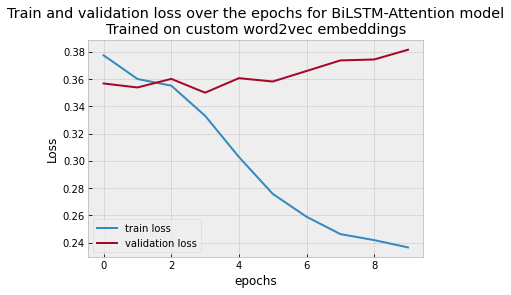

In [26]:
import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.plot(np.arange(0, len(train_l)), train_l, label="train loss")
plt.plot(np.arange(0, len(valid_l)), valid_l, label="validation loss")

# plt.plot(np.arange(0, len(train_rsme)), train_rsme, label="train RMSE")
# plt.plot(np.arange(0, len(valid_rsme)), valid_rsme, label="validation RMSE")
plt.legend(loc="best")

plt.ylabel("Loss")
plt.xlabel("epochs")

plt.title(f"Train and validation loss over the epochs for {options_models[model_to_run]} model\n"
          "Trained on custom word2vec embeddings")

plt.show()
# print(train_losses_D)
# print(train_losses_G)